<h1>Problem 1</h1> 
<t>Train and validate rnn.RNN, rnn.LSTM and rnn.GRU for learning the text sequence provided. Use sequences of 10, 20, and 30 for your training. Feel free to adjust other network parameters. Report and compare training loss, validation accuracy, execution time for training, and computational and mode size complexities across the three models over various lengths of sequence.</t>

<h2>Data Preprocessing</h2>

In [31]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchinfo import summary
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h3>Load Text File:</h3>

In [32]:
textPath = "C:/Users/aidan_000/Desktop/UNCC/Github/Intro-to-DL/datasets/text-sequences/nextchar.txt"

with open(textPath, "r") as file:
    text = file.read()

# Grab unique characters from the text
chars = sorted(list(set(text)))

# Create Dictionary to map each character to an unique int
idxTochar = {}
for i, char in enumerate(chars):
    idxTochar[i] = char
    
# Create Dictionary to map each int to a unique character
charToidx = {}
for i, char in enumerate(chars):
    charToidx[char] = i

encoded_text = [charToidx[char] for char in text]

<h3>Create Input Sequence and Dataset:</h3>

In [33]:
sequence_len = [10, 20, 30] # Input sequence length

k = 2 # 0, 1, or 2, choose input length

sequences, targets = [], []
for i in range(0, len(encoded_text) - sequence_len[k]):
    sequence = encoded_text[i: i+sequence_len[k]]
    target = encoded_text[i+sequence_len[k]]
    
    sequences.append(sequence)
    targets.append(target)

sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharacterDataset(Dataset):
    def __init__(self, features, labels):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

dataset = CharacterDataset(sequences, targets)

batch_size = 64
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Create DataLoaders for train and test sets
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

<h3>Model Training and Inferencing Function:</h3>

In [34]:
def train_model(model, criterion, optimizer, epochs, update_interval):
    
    training_losses = []
    validation_accuracies = []
    pbar_updateInterval = 0
    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_train = time.time()
        
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            train_output = model(inputs)
            train_loss = criterion(train_output, labels)
            running_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        
        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                valid_output = model(inputs)
                _, predicted = torch.max(valid_output, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        
            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            with tqdm(total=epochs, desc=f'Epoch {epoch + 1}/{epochs}', bar_format='{l_bar}{bar}|{postfix}', dynamic_ncols=True) as pbar:
                pbar.update(epoch+1)
                pbar.set_postfix({'Training Loss ':' 'f'{training_losses[-1]:.4f}', 'Validation Accuracy':f'{validation_accuracies[-1]:.2f}%'})
        
    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')
    
    return training_losses, validation_accuracies, training_time, validation_time


# Prediction function
def charInference(model, charToidx, idxTochar, initial_string):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([charToidx[c] for c in initial_string[-sequence_len[k]:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return idxTochar[predicted_index]

<h2>Next Character RNN Model</h2>

<h3>Define RNN Model:</h3>

In [35]:
class NextCharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return output

<h3>Hyperparameters and Training:</h3>

In [36]:
input_size = len(chars) 
output_size = len(chars) 
hidden_size = 128

lr = 0.003
epochs = 100
update_interval = 10

modelRNN = NextCharRNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRNN.parameters(), lr=lr)

RNN_training_losses, RNN_validation_accuracies, RNN_training_time, RNN_inference_time = train_model(modelRNN, criterion, optimizer, epochs, update_interval)

Epoch 10/100:   0%|          |

Epoch 20/100:   0%|          |

Epoch 30/100:   0%|          |

Epoch 40/100:   0%|          |

Epoch 50/100:   0%|          |

Epoch 60/100:   0%|          |

Epoch 70/100:   0%|          |

Epoch 80/100:   0%|          |

Epoch 90/100:   0%|          |

Epoch 100/100:   0%|          |


Total Duration: 7.28s
Training Duration: 0.06s
Inference Duration: 0.01s

Final Training Loss: 0.0408
Final Validation Accuracy: 44.61%


<h3>Model Inferencing and Analysis</h3>

In [37]:
# Predicting the next character
test_string = "The purpose of this model, is to predict the next character in a sequenc"
print(f"Original test string: {test_string}")
predicted_char = charInference(modelRNN, charToidx, idxTochar, test_string)
test_string += predicted_char
print(f"Updated test string: {test_string}")

Original test string: The purpose of this model, is to predict the next character in a sequenc
Updated test string: The purpose of this model, is to predict the next character in a sequence


<h2>Next Character LSTM Model</h2>

<h3>Define LSTM Model:</h3>

In [38]:
class NextCharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

<h3>Hyperparameters and Training:</h3>

In [39]:
input_size = len(chars) 
output_size = len(chars) 
hidden_size = 256

lr = 0.001
epochs = 100
update_interval = 10

modelLSTM = NextCharLSTM(len(chars), hidden_size, len(chars)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelLSTM.parameters(), lr=lr)

LSTM_training_losses, LSTM_validation_accuracies, LSTM_training_time, LSTM_inference_time = train_model(modelLSTM, criterion, optimizer, epochs, update_interval)

Epoch 10/100:   0%|          |

Epoch 20/100:   0%|          |

Epoch 30/100:   0%|          |

Epoch 40/100:   0%|          |

Epoch 50/100:   0%|          |

Epoch 60/100:   0%|          |

Epoch 70/100:   0%|          |

Epoch 80/100:   0%|          |

Epoch 90/100:   0%|          |

Epoch 100/100:   0%|          |


Total Duration: 8.44s
Training Duration: 0.07s
Inference Duration: 0.01s

Final Training Loss: 0.0032
Final Validation Accuracy: 50.11%


<h3>Model Inferencing and Analysis</h3>

In [40]:
# Predicting the next character
test_string = "The purpose of this model, is to predict the next character in a sequenc"
print(f"Original test string: {test_string}")
predicted_char = charInference(modelLSTM, charToidx, idxTochar, test_string)
test_string += predicted_char
print(f"Updated test string: {test_string}")

Original test string: The purpose of this model, is to predict the next character in a sequenc
Updated test string: The purpose of this model, is to predict the next character in a sequence


<h2>Next Character GRU Model</h2>

<h3>Define GRU Model:</h3>

In [41]:
class NextCharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output

<h3>Hyperparameters and Training:</h3>

In [42]:
input_size = len(chars) 
output_size = len(chars) 
hidden_size = 256

lr = 0.001
epochs = 100
update_interval = 10

modelGRU = NextCharGRU(len(chars), hidden_size, len(chars)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelGRU.parameters(), lr=lr)

GRU_training_losses, GRU_validation_accuracies, GRU_training_time, GRU_inference_time = train_model(modelGRU, criterion, optimizer, epochs, update_interval)

Epoch 10/100:   0%|          |

Epoch 20/100:   0%|          |

Epoch 30/100:   0%|          |

Epoch 40/100:   0%|          |

Epoch 50/100:   0%|          |

Epoch 60/100:   0%|          |

Epoch 70/100:   0%|          |

Epoch 80/100:   0%|          |

Epoch 90/100:   0%|          |

Epoch 100/100:   0%|          |


Total Duration: 8.15s
Training Duration: 0.07s
Inference Duration: 0.01s

Final Training Loss: 0.0106
Final Validation Accuracy: 45.45%


<h3>Model Inferencing and Analysis</h3>

In [43]:
# Predicting the next character
test_string = "The purpose of this model, is to predict the next character in a sequenc"
print(f"Original test string: {test_string}")
predicted_char = charInference(modelGRU, charToidx, idxTochar, test_string)
test_string += predicted_char
print(f"Updated test string: {test_string}")

Original test string: The purpose of this model, is to predict the next character in a sequenc
Updated test string: The purpose of this model, is to predict the next character in a sequence


<h2>Comparing Model Training Experiences</h2>

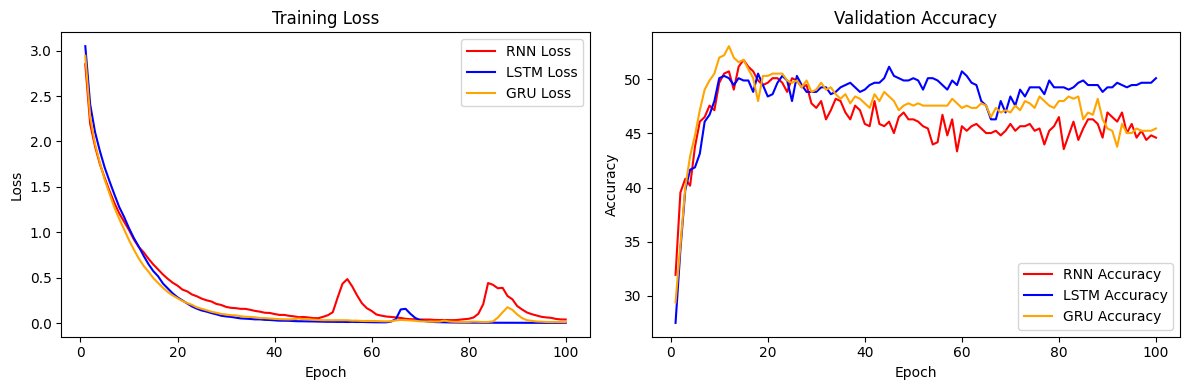

In [44]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, RNN_training_losses, label='RNN Loss', color = 'red')
plt.plot(epochs_range, LSTM_training_losses, label='LSTM Loss', color = 'blue')
plt.plot(epochs_range, GRU_training_losses, label='GRU Loss', color = 'orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, RNN_validation_accuracies, label='RNN Accuracy', color = 'red')
plt.plot(epochs_range, LSTM_validation_accuracies, label='LSTM Accuracy', color = 'blue')
plt.plot(epochs_range, GRU_validation_accuracies, label='GRU Accuracy', color = 'orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
RNN_stats = summary(modelRNN, (sequence_len[k], input_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
LSTM_stats = summary(modelLSTM, (sequence_len[k], input_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
GRU_stats = summary(modelGRU, (sequence_len[k], input_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

print(f'\n========================================= Total Time per Model =========================================')
print(f'RNN  Training Duration: {RNN_training_time:.2f}s, RNN Inference Duration: \t{RNN_inference_time:.2f}s')
print(f'LSTM Training Duration: {LSTM_training_time:.2f}s, LSTM Inference Duration: {LSTM_inference_time:.2f}s')
print(f'GRU  Training Duration: {GRU_training_time:.2f}s, GRU Inference Duration: \t{GRU_inference_time:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'RNN  Training Loss: {RNN_training_losses[-1]:.4f},  RNN Inference Accuracy: {RNN_validation_accuracies[-1]:.2f}%')
print(f'LSTM Training Loss: {LSTM_training_losses[-1]:.4f}, LSTM Inference Accuracy: {LSTM_validation_accuracies[-1]:.2f}%')
print(f'GRU  Training Loss: {GRU_training_losses[-1]:.4f},  GRU Inference Accuracy: {GRU_validation_accuracies[-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
NextCharRNN (NextCharRNN)                --               [30, 45]         --               --
├─Embedding (embedding)                  --               [30, 45, 128]    5,760            172,800
│    └─weight                            [128, 45]                         └─5,760
├─RNN (rnn)                              --               [30, 45, 128]    33,024           44,582,400
│    └─weight_ih_l0                      [128, 128]                        ├─16,384
│    └─weight_hh_l0                      [128, 128]                        ├─16,384
│    └─bias_ih_l0                        [128]                             ├─128
│    └─bias_hh_l0                        [128]                             └─128
├─Linear (fc)                            --               [30, 45]         5,805            174,150
│    └─weight                            [128, 45]                         ├─5,760
│   